# Models


### Import libraries

### Model: Neural Net

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append('../data')
from process_data import process_data
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
#turn off warnings
import warnings
warnings.filterwarnings('ignore')
IMAGE_PATH = '../data/Youtube Thumbnails/' # replace with your path
from sklearn.metrics import confusion_matrix, classification_report
import random

random.seed(77)


In [25]:
X_train, y_train,X_test,y_test = process_data(buckets = 10)

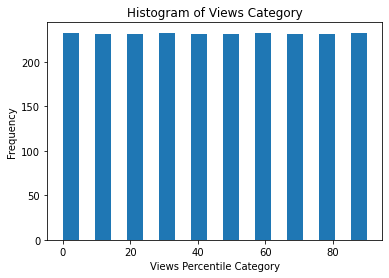

In [26]:
y = np.concatenate([y_train, y_test])

# Plot histogram
plt.hist(y, bins=19)
plt.title('Histogram of Views Category')
plt.xlabel('Views Percentile Category')
plt.ylabel('Frequency')
plt.show()

In [27]:
X_train.describe()

,num_tags,duration,days_published_channel,channel_videos,likes_to_views,comments_to_views,log_hours_published_video,log_channel_subscribers
count,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000
mean,16.434642,1124.550834,3214.200070,3563.700914,0.037356,0.003041,6.728960,13.678700
std,13.623786,1656.229609,1814.098620,14276.636270,0.034995,0.009492,2.630686,2.954320
min,0.000000,0.000000,9.119690,1.000000,0.000000,0.000000,-2.101761,0.000000
25%,3.000000,362.000000,1773.930041,139.000000,0.016139,0.000727,4.655396,12.676076
50%,16.000000,751.000000,3152.131708,408.000000,0.028725,0.001574,7.209058,14.159100
75%,27.000000,1334.000000,4413.965728,1310.000000,0.047177,0.003064,8.822257,15.590463
max,75.000000,43724.000000,6500.691858,244477.000000,0.436202,0.333333,11.681350,18.757153


In [28]:
X_test.describe()

,num_tags,duration,days_published_channel,channel_videos,likes_to_views,comments_to_views,log_hours_published_video,log_channel_subscribers
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,16.387097,1065.552688,3215.399440,3360.232258,0.037764,0.003402,6.607569,13.537325
std,13.882226,1484.180115,1803.079530,12234.889520,0.030277,0.006709,2.839235,3.116439
min,0.000000,3.000000,17.146368,1.000000,0.000821,0.000000,-1.171122,2.639057
25%,2.000000,393.000000,1746.199856,135.000000,0.017236,0.000800,4.150368,12.621488
50%,15.000000,712.000000,3152.131708,383.000000,0.030841,0.001756,7.298942,14.200773
75%,26.000000,1238.000000,4378.035257,1365.000000,0.047955,0.003630,8.961368,15.571643
max,67.000000,22052.000000,6403.041627,162859.000000,0.213642,0.101386,11.572499,18.757153


In [29]:
def preprocess_data(IMAGE_PATH):
    """ Generate lists of images and video ids
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images  (np.ndarray): Images of shape (N, 120, 90, 3)
    """
    images = []
    video_ids = []

    # create lists of images `images_mini` 
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read video ID from path
        video_id = img.split('/')[0]
        video_id = video_id.split('.')[0]
        
        # read image
        img = load_img(
            IMAGE_PATH + img
        )
        img = img.resize((320,180))
        # transform image to array
        img = img_to_array(img)

        #pre process
        img = img / 255
        
        # append to images
        images.append(img)
        
        video_ids.append(video_id)

    # stack images and trasnform to array
    images = np.stack(images)
    
    return images, video_ids

In [30]:
images = preprocess_data(IMAGE_PATH)

In [31]:
images[0].shape

(2324, 180, 320, 3)

In [32]:
train_tuple = ([], []) # tuple for train set
test_tuple = ([], []) # tuple for test set

for i in range(len(images[1])):
    if images[1][i] in X_train['video_id'].to_list():
        train_tuple[0].append(images[0][i])
        train_tuple[1].append(images[1][i])
    else:
        test_tuple[0].append(images[0][i])
        test_tuple[1].append(images[1][i])

print("Train tuple:", len(train_tuple[0]))
print("Test tuple:", len(test_tuple[0]))

Train tuple: 1859
Test tuple: 465


In [33]:
X_train = np.array(train_tuple[0])
X_test = np.array(test_tuple[0])


In [34]:
encoder = LabelEncoder()
encoder.fit(pd.concat([y_train['views_category_10'], y_test['views_category_10']]))

Y_train_cat = encoder.transform(y_train['views_category_10'])
Y_test_cat = encoder.transform(y_test['views_category_10'])

In [35]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  
  model = tf.keras.Sequential()
  model.add(keras.layers.Flatten())
  i=0
  for hidden_layer_size in hidden_layer_sizes:
    i = i+1
    model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                    activation=activation,
                                    name="Hidden"+str(i)))
  model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax', name='Output'))
  
  if optimizer == 'SGD':
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == 'Adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  else:
    print("error: invalid optimizer")

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  return model

Training...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 172800)            0         
                                                                 
 Hidden1 (Dense)             (None, 256)               44237056  
                                                                 
 Hidden2 (Dense)             (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 44,271,242
Trainable params: 44,271,242
Non-trainable params: 0
_________________________________________________________________
None


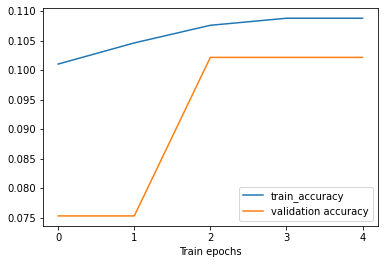

15/15 [==============================] - 1s 30ms/step


In [36]:
hidden_layer_sizes=[256,128]
activation='relu'
optimizer='Adam'
learning_rate=0.01
num_epochs=5

# Build the model.
model = build_model(n_classes=10,
                  hidden_layer_sizes=hidden_layer_sizes,
                  activation=activation,
                  optimizer=optimizer,
                  learning_rate=learning_rate)

# Train the model.
print('Training...')
history = model.fit(
x=X_train,
y=Y_train_cat,
epochs=num_epochs,
batch_size=64,
validation_split=0.1,
verbose=0)

print(model.summary())

# Retrieve the training metrics (after each train epoch) and the final test
# accuracy.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(num_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

test_accuracy = model.evaluate(x=X_test, y=Y_test_cat, verbose=0,
                             return_dict=True)['accuracy']
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)



In [37]:
print('Test Accuracy: %1.4f', test_accuracy)

Test Accuracy: %1.4f 0.06881720572710037


15/15 [==============================] - 0s 30ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.00      0.00      0.00        44
           2       0.00      0.00      0.00        58
           3       0.07      1.00      0.13        32
           4       0.00      0.00      0.00        54
           5       0.00      0.00      0.00        35
           6       0.00      0.00      0.00        40
           7       0.00      0.00      0.00        57
           8       0.00      0.00      0.00        44
           9       0.00      0.00      0.00        50

    accuracy                           0.07       465
   macro avg       0.01      0.10      0.01       465
weighted avg       0.00      0.07      0.01       465

Confusion Matrix:



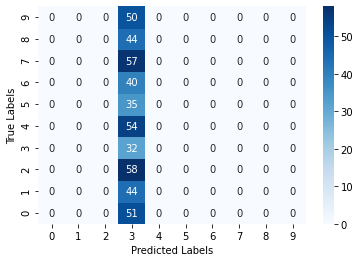

In [38]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)


cm = confusion_matrix(Y_test_cat, classes_x)
cr = classification_report(Y_test_cat, classes_x)

print("Classification Report:\n", cr)

print("Confusion Matrix:\n")
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
ax.invert_yaxis()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | EPOCHS | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-|-
thumbnails|[256,128]|tanh|SGD|0.005|10|44,271,242| 0.1097
thumbnails|[256,128]|tanh|SGD|0.02|10|44,271,242| 0.0882
thumbnails|[512,256,128]|tanh|SGD|0.01|10|88,639,626| 0.1097
thumbnails|[256,256,256,128]|tanh|SGD|0.01|10|44,402,826| 0.1097
thumbnails|[256,128]|tanh|SGD|0.01|10| 44,271,242| 0.0968
thumbnails|[256,128]|tanh|SGD|0.01|5|44,271,242|0.107
thumbnails|[256,128]|relu|Adam|0.01|5|44,271,242| 0.1269


In [39]:
IMAGE_SIZE = (320, 180)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(X_train, y_train, X_test, y_test):
    """ 
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 320, 180, 3)
    y (np.ndarray): Labels of shape (N,)   
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 320, 180, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_test (np.ndarray): Test images of shape (N_test, 320, 180, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    
    return X_train, y_train, X_test, y_test

In [40]:

print(f"X_train shape {X_train.shape}")
print(f"Y_train shape {Y_train_cat.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {Y_test_cat.shape}")

X_train shape (1859, 180, 320, 3)
Y_train shape (1859,)
X_test shape (465, 180, 320, 3)
y_test shape (465,)


In [41]:
X_train_aug, Y_train_cat_aug, X_test_aug, Y_test_cat_aug = preprocess_data_part2(X_train, Y_train_cat, X_test, Y_test_cat)

In [42]:

print(f"X_train shape {X_train_aug.shape}")
print(f"Y_train shape {Y_train_cat_aug.shape}")
print(f"X_test shape {X_test_aug.shape}")
print(f"y_test shape {Y_test_cat_aug.shape}")

X_train shape (3718, 320, 180, 3)
Y_train shape (3718,)
X_test shape (465, 320, 180, 3)
y_test shape (465,)


<u>The architecture of our CNN model is as follows</u>:

1. the model receives input images of size 320 x 180 x 3 (the images have three color channels)
2. the input data goes through two convolutional layers that have kernels of size 5 x 5
3. the first convolution has 32 output feature maps, and the second one has 64
4. each convolution layer is followed by a max-pooling layer (this will reduce the size of the feature maps)
5. the last two layers of the model are fully connected with a droput layer in between

For each convolution we use strides=(1,1) to preserve the dimension of the inputs in the resulting feature maps. For the pooling layers, we set strides=(2,2) to subsample the image and shrink the size of the output feature maps. For the dropout layer, we set the probability of dropping input units during training to 0.5.


We will implement this architecture using TensorFlow Keras API.

In [59]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3, 3),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(3, 3), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
model.add(tf.keras.layers.Dense(
    units=10,
    activation='softmax',
    name='Output'))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 320, 180, 3))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 320, 180, 16)      448       
                                                                 
 pool_1 (MaxPooling2D)       (None, 106, 60, 16)       0         
                                                                 
 conv_2 (Conv2D)             (None, 106, 60, 32)       4640      
                                                                 
 pool_2 (MaxPooling2D)       (None, 35, 20, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 22400)             0         
                                                                 
 fc_1 (Dense)                (None, 1024)              22938624  
                                                                 
 dropout_2 (Dropout)         (None, 1024)             

In [60]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [61]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train_aug, Y_train_cat_aug,
                    epochs=10, 
                    validation_data=(X_test_aug, Y_test_cat_aug)
)

Epoch 1/10
117/117 [==============================] - 57s 479ms/step - loss: 2.3327 - accuracy: 0.1103 - val_loss: 2.3022 - val_accuracy: 0.1097
Epoch 2/10
117/117 [==============================] - 50s 430ms/step - loss: 2.2805 - accuracy: 0.1409 - val_loss: 2.3059 - val_accuracy: 0.1054
Epoch 3/10
117/117 [==============================] - 46s 391ms/step - loss: 2.2547 - accuracy: 0.1678 - val_loss: 2.3105 - val_accuracy: 0.0860
Epoch 4/10
117/117 [==============================] - 47s 403ms/step - loss: 2.2178 - accuracy: 0.1963 - val_loss: 2.3148 - val_accuracy: 0.1032
Epoch 5/10
117/117 [==============================] - 47s 401ms/step - loss: 2.1675 - accuracy: 0.2335 - val_loss: 2.3287 - val_accuracy: 0.0774
Epoch 6/10
117/117 [==============================] - 52s 441ms/step - loss: 2.1025 - accuracy: 0.2703 - val_loss: 2.3464 - val_accuracy: 0.0624
Epoch 7/10
117/117 [==============================] - 44s 377ms/step - loss: 2.0147 - accuracy: 0.3209 - val_loss: 2.3913 - val_ac

In [46]:
predict_x=model.predict(X_test_aug) 
classes_x=np.argmax(predict_x,axis=1)

15/15 [==============================] - 2s 95ms/step


In [47]:
unique, counts = np.unique(classes_x, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  2  30]
 [  6   1]
 [  7 434]]


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.00      0.00      0.00        44
           2       0.13      0.07      0.09        58
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        54
           5       0.00      0.00      0.00        35
           6       0.00      0.00      0.00        40
           7       0.12      0.95      0.22        57
           8       0.00      0.00      0.00        44
           9       0.00      0.00      0.00        50

    accuracy                           0.12       465
   macro avg       0.03      0.10      0.03       465
weighted avg       0.03      0.12      0.04       465

Confusion Matrix:



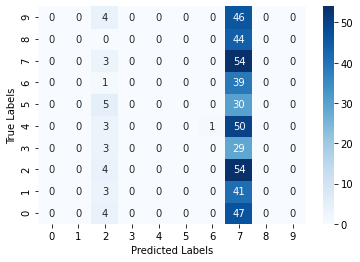

In [48]:

cm = confusion_matrix(Y_test_cat_aug, classes_x)
cr = classification_report(Y_test_cat_aug, classes_x)

print("Classification Report:\n", cr)

print("Confusion Matrix:\n")
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
ax.invert_yaxis()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


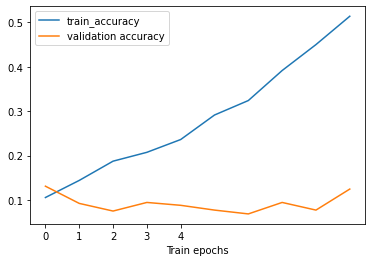

In [49]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(num_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

*Written answer*:

| Training accuracy | Validation accuracy |  kernel size |  strides | pool size  |  learning rate | optimizer  | brightness (delta) |  contrast factor | flip_on_train  |
|:-:                |:-:                  |:-:           |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:             |
| 0.9618              | 0.0968                | 5,5          | 1,1      | 3,3        | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.9680              | 0.1097                 | <font color="red">3,3</font>     | 1,1      | 3,3        | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.8886               | 0.0882                 | 3,3          | <font color="red">2,2</font>  | 3,3        | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.9648               | 0.0946                 | 3,3          | 1,1      | 3,3   | 0.001          | Adam       | <font color="red">0.1</font>                | 3                | yes            |
| 0.9683               | 0.0839                 | 3,3          | 1,1      | 2,2        | 0.001       | Adam       | 0.3                | <font color="red">2</font>                | yes            |
| 0.6119               | 0.1054                 | 3,3          | 1,1      | 2,2        | 0.001          |<font color="red">SGD</font>     | 0.3                | 3                | yes            |


In [62]:
vgg16_label_df = pd.read_csv('../data/vgg16.csv',index_col=0)


In [63]:
vgg16_label_df

,video_id,label_1,label_2,label_3
0,rpe5kB2eGvo,sarong,book_jacket,hoopskirt
1,MvuqM_9h6QY,Band_Aid,packet,comic_book
2,ZcGlf7EZ-vU,comic_book,book_jacket,panpipe
3,hDk1ne5TCHM,scoreboard,digital_clock,hand-held_computer
4,-X0eQXFbTQo,book_jacket,comic_book,Band_Aid
...,...,...,...,...
2319,A7cWtICGgHE,comic_book,book_jacket,jersey
2320,d-HPZL6AU64,panpipe,maillot,comic_book
2321,UfwXf7AisAs,book_jacket,guillotine,fire_screen
2322,LqmmjHEyiHM,suit,trench_coat,Windsor_tie
